In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import metrics

In [2]:
train = pd.read_csv('df_training_scholarjet.csv', index_col='cuid').drop('Unnamed: 0', axis='columns')
test = pd.read_csv('df_holdout_scholarjet.csv', index_col='cuid').drop('Unnamed: 0', axis='columns')

# Preprocess Independent Variables


In [3]:
train = pd.get_dummies(train).reset_index()

In [4]:
# Skew Correction
skewed = train.columns[(abs(train.skew()) > 20).values]
def correct_skew(data):
    for col in data.columns:
        if col in skewed:
            data[col] = np.log1p(data[col])
    return data

In [5]:
train = correct_skew(train)

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


In [6]:
X = train.drop(['cuid', 'convert_30', 'revenue_30'], axis='columns', errors='ignore')

In [7]:
# Median fill NaNs
X = X.fillna(value = {x: X[x].median() for x in X.columns})

# Drop fully NaN columns
all_nan = X.isna().sum()[X.isna().sum() > 0].index
X = X.drop(all_nan, axis='columns')

# Preliminary Gradient Boosting for Feature Selection


In [8]:
y_convert = train.convert_30

In [9]:
X_train, y_train = X, y_convert
conversion_model = xgb.XGBClassifier(scale_pos_weight=4)
conversion_model.fit(X_train, y_train)
xgb_features = pd.DataFrame(conversion_model.feature_importances_, X_train.columns).sort_values(0, ascending=False)

In [10]:
# Select Features
top_20_conversion = xgb_features[:20]
xgb_train = X[top_20_conversion.index]
top_20_conversion.head()

,0
dayssincelastvisit,0.118141
numtotalpageviewsthirtyseven,0.053692
sumatcprice,0.038127
numskusviewedthirtyseven,0.035448
numatcsixtythirty,0.033027


# Gradient Boosting for Conversion Classification

In [11]:
X_train = xgb_train
conversion_model = xgb.XGBClassifier(scale_pos_weight=4)
conversion_model.fit(X_train, y_train)
xgb_features = pd.DataFrame(conversion_model.feature_importances_, X_train.columns).sort_values(0, ascending=False)

# Extract Converted Training Samples

In [12]:
index_converted = train[train.convert_30==1].index
X_converted = X.loc[index_converted]

In [13]:
y_revenue = train.loc[index_converted].revenue_30
y_revenue.shape

(2928,)

# Prelim Gradient Boosting for Regression Feature Selection

In [14]:
X_train, y_train = X_converted, y_revenue
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb_revenue_features = pd.DataFrame(model.feature_importances_, X_train.columns).sort_values(0, ascending=False)

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:49:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
top_20_revenue = xgb_revenue_features[:20]
X_converted = X_converted[top_20_revenue.index]
X_converted.shape

(2928, 20)

# Train Gradient Boosting Model for Revenue Prediciton

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X_converted, y_revenue, test_size=0.25)
X_train, y_train = X_converted, y_revenue
revenue_model = xgb.XGBRegressor()
revenue_model.fit(X_train, y_train)

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:49:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

# Preprocess Test Data

In [17]:
test = pd.get_dummies(test).reset_index()
test = correct_skew(test)
X = test.drop(['cuid', 'convert_30', 'revenue_30'], axis='columns', errors='ignore')
X = X.fillna(value = {x: X[x].median() for x in X.columns})
all_nan = X.isna().sum()[X.isna().sum() > 0].index
X = X.drop(all_nan, axis='columns')

/Users/kylemaxwell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


In [18]:
X_test_conversion = X[top_20_conversion.index]
X_test_revenue = X[top_20_revenue.index]

# Extract Samples Predicted to be Converted

In [19]:
y_conv_pred = conversion_model.predict(X_test_conversion)
pd.Series(y_conv_pred).value_counts()

0    26817
1     3558
dtype: int64

In [20]:
index_converted = test[y_conv_pred==1].index

X_converted = X_test_revenue.loc[index_converted]
X_converted.shape

(3558, 20)

# Perform Revenue Prediction

In [21]:
y_revenue_pred = np.expm1(revenue_model.predict(X_converted))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1047a1e10>]],
      dtype=object)

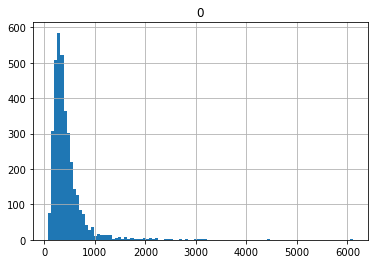

In [22]:
pd.DataFrame(y_revenue_pred).hist(bins=100)

# Assemble Predictions

In [23]:
df = test[['cuid']].copy()
df.columns = ['CuID']
df['pred_convert_30'] = y_conv_pred
revenue = pd.DataFrame(y_revenue_pred, columns=['pred_revenue_30'], index=index_converted)
predictions = df.join(revenue).fillna(0.0)

In [24]:
predictions.head()

,CuID,pred_convert_30,pred_revenue_30
0,16838,0,0.000000
1,532175,0,0.000000
2,532176,1,324.274170
3,532187,1,929.831421
4,16938,0,0.000000


In [39]:
predictions.to_csv('WayfairChallenge.csv')